# Implementation of figure 2 in softmax is not enough paper
 - Goal - show out of distribution sequence lengths do not have sharp attention
 - Methodology - train single attention layer on max seq len of 16, plot highest attention weights for seqeunces lengths 16, 32, 64, ..., see if attention is sharp.
 - The task is retrieving the max element in a random sequence

In [ ]:
import numpy as np
import torch
from tqdm import tqdm

def make_dataset(len_dataset: int, max_len_seq: int):
    data = []
    seqs = [np.random.randint(low=0, high=30, size=max_len_seq) for _ in tqdm(range(len_dataset), desc='generating nums')]

    for seq in tqdm(seqs, desc='creating dataset'):
        for i, _ in enumerate(seq):
            x = seq[:i+1]
            y = max(x)
            data.append((torch.tensor(x),torch.tensor(y)))

    return data

dataset = make_dataset(3, 4)
dataset

creating dataset: 100%|██████████| 3/3 [00:00<00:00, 5918.59it/s]


[(tensor([28]), tensor(28)),
 (tensor([28, 10]), tensor(28)),
 (tensor([28, 10, 10]), tensor(28)),
 (tensor([28, 10, 10, 19]), tensor(28)),
 (tensor([17]), tensor(17)),
 (tensor([17,  0]), tensor(17)),
 (tensor([17,  0, 16]), tensor(17)),
 (tensor([17,  0, 16, 28]), tensor(28)),
 (tensor([9]), tensor(9)),
 (tensor([ 9, 18]), tensor(18)),
 (tensor([ 9, 18,  6]), tensor(18)),
 (tensor([ 9, 18,  6, 13]), tensor(18))]

In [ ]:
dataset = make_dataset(5000, 16)

creating dataset: 100%|██████████| 5000/5000 [00:01<00:00, 3417.04it/s]


In [ ]:
import random

class MaxDataLoader:
    def __init__(self, dataset, batch_size, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __iter__(self):
        self.idx = 0
        if self.shuffle: random.shuffle(self.dataset)

        return self

    def __next__(self):
        if self.idx >= len(self.dataset): raise StopIteration
        batch = self.dataset[self.idx : self.idx + self.batch_size]
        self.idx += self.batch_size

        xs, ys = zip(*batch)
        return list(xs), torch.stack(ys)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class SelfAttnLayer(nn.Module):
    def __init__(self, d_emb):
        super().__init__()
        self.c_attn = nn.Linear(d_emb, 3 * d_emb)
        self.c_proj = nn.Linear(d_emb, d_emb)
        self.fc = nn.Linear(d_emb, 1)
        self.d_emb = d_emb

    def forward(self, x, return_attn=False):
        B, T, C = x.size()
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.d_emb, dim=2)

        scale = q.size(-1) ** -0.5
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) * scale  #(B, T, T)

        # Causal mask removed for this task, allowing global attention.
        # mask = torch.triu(torch.ones(T, T, device=x.device), diagonal=1).bool()
        # attn_scores = attn_scores.masked_fill(mask, float('-inf'))

        attn_weights = torch.softmax(attn_scores, dim=-1)  #(B, T, T)
        y = torch.matmul(attn_weights, v)  #(B, T, C)

        y = self.c_proj(y)
        out = self.fc(y)

        return (out, attn_weights, attn_scores) if return_attn else out


#hyperparameters
d_emb = 16
epochs = 15
batch_size = 32
max_len_seq = 16
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#dataset
train = make_dataset(500, max_len_seq)
dev = make_dataset(50, max_len_seq)
dataloader = MaxDataLoader(train, batch_size)
val_loader = MaxDataLoader(dev, batch_size)

#model
embedding = nn.Embedding(30, d_emb).to(device)
model = SelfAttnLayer(d_emb).to(device)
optimizer = optim.AdamW(list(model.parameters()) + list(embedding.parameters()), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(epochs):
    dataloader = MaxDataLoader(train, batch_size)
    total_loss = 0
    for xs, ys in  dataloader:
        ys = ys.to(device)
        optimizer.zero_grad()
        batch_losses = []

        for x, y in zip(xs, ys):
            x=x.to(device)

            emb = embedding(x).unsqueeze(0)  #(1, T, d_emb)
            out = model(emb)  #(1, T, 1)
            pred = out[0, -1, 0]  #last token predicts max
            loss = loss_fn(pred, y.float())
            batch_losses.append(loss)

        batch_loss = torch.stack(batch_losses).mean()
        batch_loss.backward()
        optimizer.step()
        total_loss += batch_loss.item()

        #val
        #model.eval()
        #val_loss = 0
        # with torch.no_grad():
        #     for xs, ys in val_loader:
        #         ys = ys.to(device)
        #         batch_losses = []

        #         for x, y in zip(xs, ys):
        #             x = x.to(device)

        #             emb = embedding(x).unsqueeze(0)
        #             out = model(emb)
        #             pred = out[0, -1, 0]
        #             loss = loss_fn(pred, y.float())
        #             batch_losses.append(loss)

        #         batch_loss = torch.stack(batch_losses).mean()
        #         val_loss += batch_loss.item()
    print(f'Epoch {epoch+1} | Train Loss: {total_loss:.4f}')# | Val Loss: {val_loss:.4f}')

creating dataset: 100%|██████████| 50/50 [00:00<00:00, 4351.57it/s]


Epoch 1 | Train Loss: 62453.0065
Epoch 2 | Train Loss: 5932.3636
Epoch 3 | Train Loss: 3484.5023
Epoch 4 | Train Loss: 1785.0335
Epoch 5 | Train Loss: 915.5093
Epoch 6 | Train Loss: 571.9804
Epoch 7 | Train Loss: 300.1449
Epoch 8 | Train Loss: 151.8127
Epoch 9 | Train Loss: 97.9181
Epoch 10 | Train Loss: 69.5121
Epoch 11 | Train Loss: 51.4986
Epoch 12 | Train Loss: 39.5354
Epoch 13 | Train Loss: 31.1902
Epoch 14 | Train Loss: 25.3153
Epoch 15 | Train Loss: 21.0719


In [ ]:
# def get_validation_set(batch_size=4, start_max_seq_len=2, num_seq_len_doubles=3):
#     curr_max_seq_len = start_max_seq_len
#     for _ in range(num_seq_len_doubles):
#         batch_arrays = torch.from_numpy(np.array([np.sort(np.random.randint(0, 30, curr_max_seq_len)) for _ in range(batch_size)]))
#         print(batch_arrays)
#         curr_max_seq_len *= 2
# get_validation_set()

# -->
# tensor([[23, 25],
#         [19, 22],
#         [ 0, 20],
#         [ 0, 13]])
# tensor([[ 1,  7,  8, 28],
#         [12, 14, 19, 20],
#         [ 3,  8, 17, 20],
#         [ 4, 14, 14, 15]])
# tensor([[ 0,  2,  6,  7, 13, 15, 18, 29],
#         [ 2,  4,  9, 11, 14, 18, 18, 18],
#         [ 2,  4,  9, 11, 16, 20, 23, 28],
#         [ 0,  1, 18, 22, 24, 24, 28, 29]])


#--not supposed to be sorted before giving to model

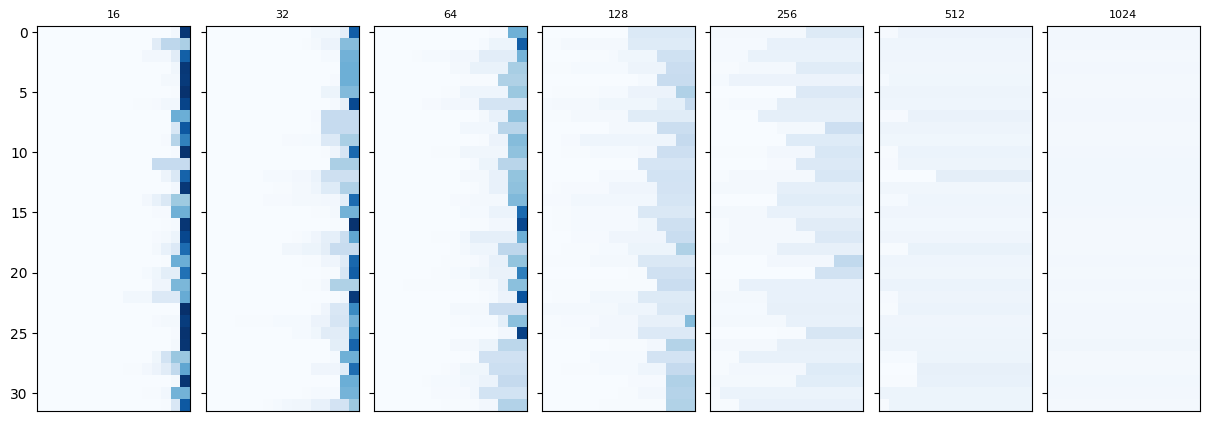

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

#NOTE: paper uses 11 different doubles for max_seq_len, but I am reaching OOM for L4 gpu for large sequences (16 * 2^11)

def plot_max_retrieval_attention(model, embedding, device, start_len=16, num_doubles=7, batch_size=32):
    """
    plots attention maps identical to Figure 2 from the paper.
    The columns are sorted by the input item's actual value in ascending order.
    """
    model.eval()
    fig, axes = plt.subplots(1, num_doubles, figsize=(15, 5), sharey=True)
    fig.subplots_adjust(wspace=0.1)

    current_len = start_len
    for i in range(num_doubles):
        ax = axes[i]

        xs = torch.randint(0, 30, (batch_size, current_len)).to(device)

        with torch.no_grad():
            emb = embedding(xs)
            _, attn_weights, _ = model(emb, return_attn=True)

        final_token_weights = attn_weights[:, -1, :] #(batch_size, current_len)
        sorted_value_indices = torch.argsort(xs, dim=1)

        top_16_value_indices = sorted_value_indices[:, -16:]

        top_k_weights = torch.gather(final_token_weights, 1, top_16_value_indices)

        im = ax.imshow(top_k_weights.cpu().numpy(), cmap='Blues', aspect='auto', vmin=0, vmax=1)

        ax.set_title(f"{current_len}", fontsize=8) ; ax.set_xticks([])

        current_len *= 2

    plt.show()

plot_max_retrieval_attention(model, embedding, device)